# Setting up project, importing the libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy import stats
import xgboost as xgb
import sys

In [21]:
!pip install seaborn

# Loading the Dataset

In [22]:
data = pd.read_csv("merged_output.csv")

data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d-%m-%y %H:%M')
data.drop(['Date', 'Time'], axis=1, inplace=True)

le = LabelEncoder()
data['Crypto'] = le.fit_transform(data['Crypto'])
data['News Headline Summary'] = le.fit_transform(data['News Headline Summary'])

data['Volume'] = data['Volume'].str.replace(r'\D', '', regex=True).astype(float)

# Data Exploration and Visualization

In [23]:
# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nDataset Information:")
data.info()

print("\nStatistical Summary:")
data.describe()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (67465, 9)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67465 entries, 0 to 67464
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Crypto                 67465 non-null  int64         
 1   Open Price             67465 non-null  int64         
 2   Close Price            67465 non-null  int64         
 3   High Price             67465 non-null  int64         
 4   Low Price              67465 non-null  int64         
 5   Volume                 67465 non-null  float64       
 6   Sentiment Score        67465 non-null  float64       
 7   News Headline Summary  67465 non-null  int64         
 8   Datetime               67465 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 4.6 MB

Statistical Summary:

Missing Values:
Crypto                   0
Open Price               0
Close Price              0
High P

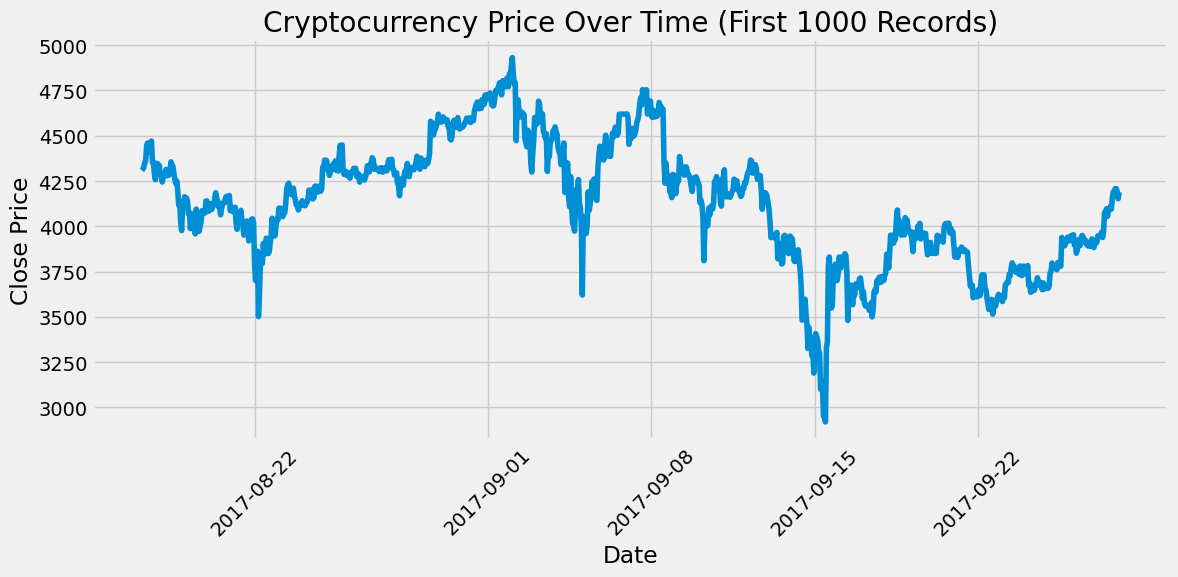

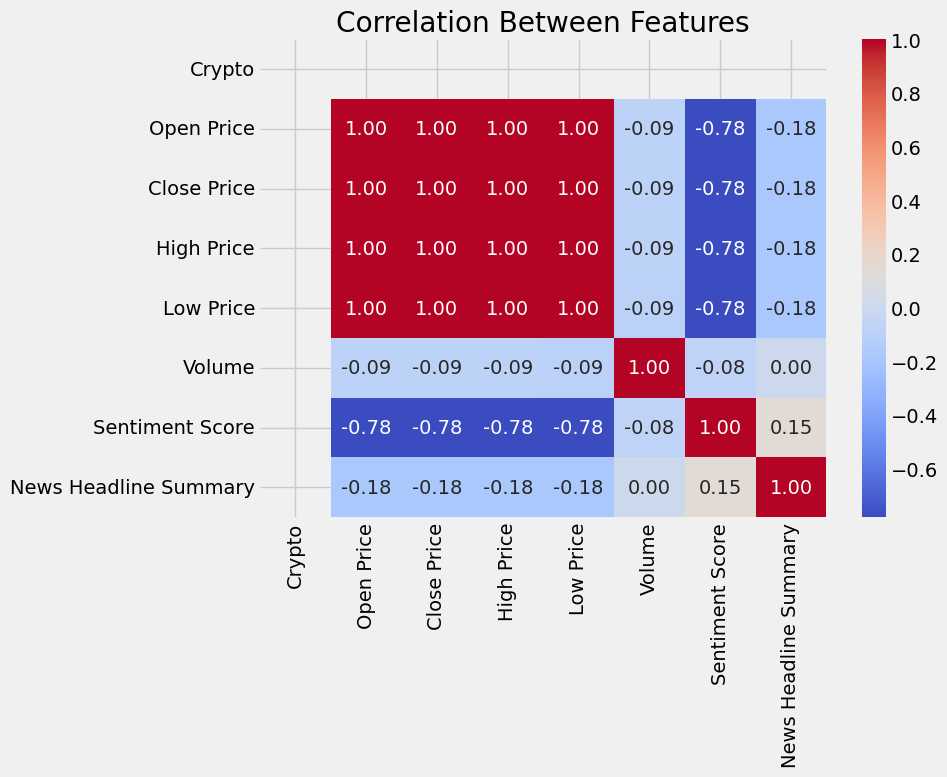

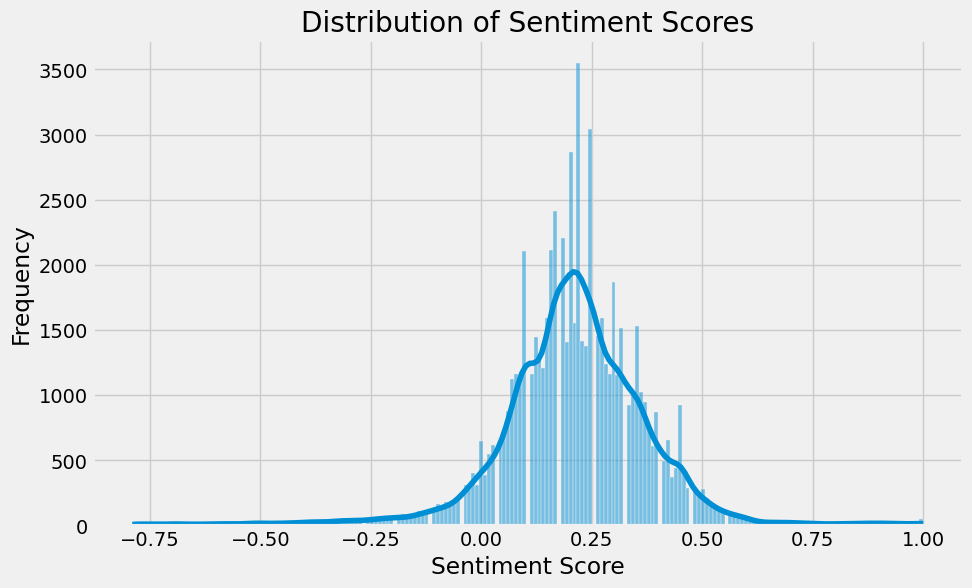

In [24]:
# Set plotting style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))

# Plot cryptocurrency price over time
plt.plot(data['Datetime'][:1000], data['Close Price'][:1000])
plt.title('Cryptocurrency Price Over Time (First 1000 Records)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization for correlation between features
plt.figure(figsize=(10, 8))
correlation = data.drop(['Datetime'], axis=1).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data['Sentiment Score'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Configuring Matplotlib

In [25]:
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

# Data Loading Function

In [26]:
def load_data(file_path):
    """
    Load data from CSV file and prepare for use in prediction models.

    Args:
        file_path (str): Path to the CSV file containing cryptocurrency data

    Returns:
        pd.DataFrame: Processed dataframe with standardized column names
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with shape: {df.shape}")
        print(f"Columns in the data: {df.columns.tolist()}")
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

    # Check if key columns exist and rename them
    column_mapping = {
        'Open Price': 'Open',
        'Close Price': 'Close',
        'High Price': 'High',
        'Low Price': 'Low',
        'Sentiment Score': 'Sentiment',
        'News Headline Summary': 'News'
    }

    existing_cols = {k: v for k, v in column_mapping.items() if k in df.columns}
    if existing_cols:
        df.rename(columns=existing_cols, inplace=True)
    else:
        print("Warning: None of the expected column names were found.")

        expected_renamed = set(['Open', 'Close', 'High', 'Low', 'Sentiment', 'News'])
        if not any(col in df.columns for col in expected_renamed):
            print("Required columns not found in either original or renamed format.")

    # Parsing the date, time column
    if 'Date' in df.columns and 'Time' in df.columns:
        try:
            df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%y %H:%M')
        except ValueError:
            print("Warning: Date format not as expected. Trying flexible date parsing.")
            df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
        if df['DateTime'].notna().any():
            df.set_index('DateTime', inplace=True)
        else:
            print("Warning: Failed to parse dates. Using default index.")
    else:
        print("Warning: Date or Time columns not found. Using default index.")

    essential_cols = ['Open', 'Close', 'High', 'Low']
    missing = [col for col in essential_cols if col not in df.columns]
    if missing:
        print(f"Warning: Missing essential columns: {missing}")
        # Create dummy columns for missing data
        for col in missing:
            if col == 'Close' and 'Open' in df.columns:
                # If we have Open but not Close, use Open as a proxy
                df['Close'] = df['Open']
            elif col == 'Open' and 'Close' in df.columns:
                # If we have Close but not Open, use Close as a proxy
                df['Open'] = df['Close']
            elif col == 'High' and 'Close' in df.columns and 'Open' in df.columns:
                # If we have Close and Open but not High, use max of Close and Open
                df['High'] = df[['Close', 'Open']].max(axis=1)
            elif col == 'Low' and 'Close' in df.columns and 'Open' in df.columns:
                # If we have Close and Open but not Low, use min of Close and Open
                df['Low'] = df[['Close', 'Open']].min(axis=1)
            else:
                df[col] = 0.0
                print(f"Created dummy column for {col} with zeros")

    print(f"Final dataframe shape: {df.shape}")
    return df

# Data Quality Function

In [27]:
def check_data_quality(df, price_columns=['Open', 'Close', 'High', 'Low']):
    """
    Check data quality and report statistics.

    Args:
        df (pd.DataFrame): DataFrame to check
        price_columns (list): List of price column names to analyze

    Returns:
        dict: Dictionary with quality metrics
    """
    quality_metrics = {}

    # Check for any extreme values in the price columns
    for col in price_columns:
        if col in df.columns:
            # Calculate percentiles
            q99 = np.percentile(df[col], 99)
            q01 = np.percentile(df[col], 1)

            # Get basic stats
            stats = {
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'median': df[col].median(),
                'std': df[col].std(),
                'q01': q01,
                'q99': q99,
                'missing': df[col].isna().sum()
            }

            # Check for unusual jumps
            pct_changes = df[col].pct_change().abs()
            large_changes = pct_changes[pct_changes > 0.1].count()
            stats['large_changes'] = large_changes
            stats['large_changes_pct'] = large_changes/len(df)*100

            # Biggest single change
            if not pct_changes.empty:
                max_change_idx = pct_changes.idxmax()
                if max_change_idx is not None:
                    stats['max_change_pct'] = pct_changes.loc[max_change_idx] * 100
                    stats['max_change_date'] = max_change_idx

            quality_metrics[col] = stats

    return quality_metrics

# Feature Engineering Functions

In [28]:
def engineer_features(df):
    """
    Create various time series features from price data.

    Args:
        df (pd.DataFrame): DataFrame containing cryptocurrency price data

    Returns:
        pd.DataFrame: DataFrame with added features
    """

    df_features = df.copy()

    print(f"DataFrame shape before feature engineering: {df_features.shape}")

    if df_features.empty:
        print("WARNING: Empty dataframe passed to feature engineering. Returning empty dataframe.")
        return df_features

    # Target: Future price movement (next hour's close price)
    df_features['Target'] = df_features['Close'].shift(-1)

    # Handle the last row target
    if df_features['Target'].isna().sum() > 0:
        print("Filling last row Target with current Close price")
        df_features['Target'] = df_features['Target'].fillna(df_features['Close'])

    # Basic price features
    df_features['Price_Change'] = df_features['Close'] - df_features['Open']
    df_features['Range'] = df_features['High'] - df_features['Low']
    df_features['Range_Pct'] = df_features['Range'] / df_features['Open'].replace(0, np.nan)
    df_features['Range_Pct'].fillna(0, inplace=True)
    df_features['Close_Pct_Change'] = df_features['Close'].pct_change().fillna(0)
    df_features['Open_Pct_Change'] = df_features['Open'].pct_change().fillna(0)

    # More robust handling of volume data
    if 'Volume' in df_features.columns:
        # Convert Volume to numeric, handling text like "BTC"
        try:
            df_features['Volume'] = df_features['Volume'].astype(str).str.extract(r'([\d.]+)').astype(float)

            # Replace any infinite values with NaN
            df_features['Volume'].replace([np.inf, -np.inf], np.nan, inplace=True)

            # Calculate reasonable volume change - with safety checks
            if df_features['Volume'].notna().sum() > 0 and not (df_features['Volume'] == 0).all():
                # Fill zeros with small value to avoid division by zero
                df_features['Volume'] = df_features['Volume'].replace(0, 0.0001)
                df_features['Volume_Pct_Change'] = df_features['Volume'].pct_change().fillna(0)
                # Cap extreme changes to prevent infinity values
                df_features['Volume_Pct_Change'] = df_features['Volume_Pct_Change'].clip(-10, 10)
            else:
                print("WARNING: Invalid Volume data. Creating dummy Volume features.")
                median_price = df_features['Close'].median()
                df_features['Volume'] = median_price / 100
                df_features['Volume_Pct_Change'] = df_features['Close_Pct_Change']
        except Exception as e:
            print(f"WARNING: Error processing Volume data: {e}. Creating proxy Volume features.")
            median_price = df_features['Close'].median()
            df_features['Volume'] = median_price / 100
            df_features['Volume_Pct_Change'] = df_features['Close_Pct_Change']
    else:
        print("WARNING: Volume column not found. Creating proxy Volume features.")
        # Create dummy Volume with median price as a proxy
        median_price = df_features['Close'].median()
        df_features['Volume'] = median_price / 100
        df_features['Volume_Pct_Change'] = df_features['Close_Pct_Change']

    # Lag features - previous hours' prices
    for i in range(1, 4):  # 1-hour, 2-hour, 3-hour lags
        df_features[f'Close_Lag_{i}'] = df_features['Close'].shift(i).fillna(method='bfill')
        df_features[f'Open_Lag_{i}'] = df_features['Open'].shift(i).fillna(method='bfill')
        df_features[f'Volume_Lag_{i}'] = df_features['Volume'].shift(i).fillna(method='bfill')
        # Add Sentiment lag only if Sentiment exists
        if 'Sentiment' in df_features.columns:
            df_features[f'Sentiment_Lag_{i}'] = df_features['Sentiment'].shift(i).fillna(method='bfill')

    # Rolling window features with safety checks
    for window in [3, 6, 12]:
        # Price rolling features
        df_features[f'Close_Rolling_Mean_{window}'] = df_features['Close'].rolling(window=window, min_periods=1).mean()
        df_features[f'Close_Rolling_Std_{window}'] = df_features['Close'].rolling(window=window, min_periods=1).std().fillna(0)

        # Volume rolling features - with safety checks
        df_features[f'Volume_Rolling_Mean_{window}'] = df_features['Volume'].rolling(window=window, min_periods=1).mean()

        # Price momentum - handle division by zero or NaN with safety checks
        roll_mean_col = f'Close_Rolling_Mean_{window}'
        df_features[roll_mean_col] = df_features[roll_mean_col].replace(0, np.nan)

        # Safe division for momentum calculation
        df_features[f'Price_Momentum_{window}'] = np.where(
            df_features[roll_mean_col].notna() & (df_features[roll_mean_col] != 0),
            (df_features['Close'] / df_features[roll_mean_col]) - 1,
            0
        )

        # Ensure no infinity values
        df_features[f'Price_Momentum_{window}'] = df_features[f'Price_Momentum_{window}'].replace([np.inf, -np.inf], 0)

    # Add volatility metrics with safety checks
    roll_mean_3 = df_features['Close_Rolling_Mean_3'].replace(0, np.nan)
    df_features['Volatility_3'] = np.where(
        roll_mean_3.notna() & (roll_mean_3 != 0),
        df_features['Close_Rolling_Std_3'] / roll_mean_3,
        0
    )
    df_features['Volatility_3'] = df_features['Volatility_3'].clip(0, 1.0)

    # Add trend direction features
    df_features['Trend_Direction'] = np.sign(df_features['Close_Pct_Change']).fillna(0)

    # Safe calculation for trend strength
    roll_mean_12 = df_features['Close_Rolling_Mean_12'].replace(0, np.nan)
    df_features['Trend_Strength'] = np.where(
        roll_mean_12.notna() & (roll_mean_12 != 0),
        (df_features['Close'] - roll_mean_12).abs() / roll_mean_12,
        0
    )
    df_features['Trend_Strength'] = df_features['Trend_Strength'].clip(0, 1.0)

    # Add normalized returns - less prone to scaling issues
    df_features['Normalized_Return'] = df_features['Close_Pct_Change'].clip(-0.2, 0.2)

    # Add volatility regime indicator
    vol = df_features['Close_Rolling_Std_12'] / df_features['Close_Rolling_Mean_12'].replace(0, np.nan).fillna(0)
    df_features['Volatility_Regime'] = np.where(vol > vol.median(), 1, 0)

    # Final check for any infinite values
    for col in df_features.columns:
        if df_features[col].dtype == float:
            df_features[col] = df_features[col].replace([np.inf, -np.inf], 0)
            # Also clip extremely large values
            if col != 'Close' and col != 'Open' and col != 'High' and col != 'Low' and col != 'Target':
                upper_limit = df_features[col].quantile(0.99)
                lower_limit = df_features[col].quantile(0.01)
                df_features[col] = df_features[col].clip(lower_limit, upper_limit)

    # Count NaN values
    nan_count = df_features.isna().sum().sum()
    print(f"Number of NaN values after feature engineering: {nan_count}")
    print(f"DataFrame shape: {df_features.shape}")

    return df_features

# Preprocessing Functions

In [29]:
def process_text_features(df, n_components=5):
    """
    Process news headlines using TF-IDF and SVD for dimensionality reduction.

    Args:
        df (pd.DataFrame): DataFrame containing news headline data
        n_components (int): Number of components to extract with SVD

    Returns:
        tuple: (news_features DataFrame, tfidf_vectorizer, svd_model)
    """
    # Check if News column exists
    if 'News' not in df.columns:
        print("WARNING: 'News' column not found. Creating dummy news features.")
        # Create dummy features with zeros
        news_df = pd.DataFrame(
            np.zeros((len(df), n_components)),
            index=df.index,
            columns=[f'News_SVD_{i}' for i in range(n_components)]
        )
        # Return dummy objects
        return news_df, None, None

    # Initialize TF-IDF Vectorizer with more features
    tfidf = TfidfVectorizer(max_features=200, stop_words='english', ngram_range=(1, 2))

    # Fill missing values in News column with empty string
    df['News'] = df['News'].fillna('')

    # Ensure we have at least one non-empty string for TF-IDF
    if df['News'].str.strip().str.len().sum() == 0:
        print("WARNING: No text content found in News column. Creating dummy features.")
        news_df = pd.DataFrame(
            np.zeros((len(df), n_components)),
            index=df.index,
            columns=[f'News_SVD_{i}' for i in range(n_components)]
        )
        return news_df, None, None

    # Transform news headlines into TF-IDF features
    tfidf_matrix = tfidf.fit_transform(df['News'])

    # Use SVD for dimensionality reduction
    svd = TruncatedSVD(n_components=min(n_components, tfidf_matrix.shape[1]))
    news_features = svd.fit_transform(tfidf_matrix)

    # If SVD used fewer components than requested, pad with zeros
    if news_features.shape[1] < n_components:
        padding = np.zeros((news_features.shape[0], n_components - news_features.shape[1]))
        news_features = np.hstack((news_features, padding))

    # Create a DataFrame with the reduced features
    news_df = pd.DataFrame(
        news_features,
        index=df.index,
        columns=[f'News_SVD_{i}' for i in range(n_components)]
    )

    return news_df, tfidf, svd



def prepare_data_for_training(df_features, news_features):
    """
    Combine features and prepare data for model training.

    Args:
        df_features (pd.DataFrame): DataFrame with price-based features
        news_features (pd.DataFrame): DataFrame with text-based features

    Returns:
        tuple: (X_scaled, y, scaler) - Features, target and the fitted scaler
    """

    if len(df_features) == 0:
        print("ERROR: Features dataframe is empty. Checking raw dataframe...")
        raise ValueError("Empty features dataframe. Check your data loading and processing.")

    # Verify index counts
    print(f"df_features index count: {len(df_features.index)}")
    print(f"news_features index count: {len(news_features.index)}")

    # Check if indices match before concatenation
    if not df_features.index.equals(news_features.index):
        print("WARNING: Indices don't match in prepare_data_for_training. Aligning dataframes...")
        common_indices = df_features.index.intersection(news_features.index)
        print(f"Found {len(common_indices)} common indices")

        if len(common_indices) == 0:
            raise ValueError("No common indices between feature sets - cannot proceed")

        df_features = df_features.loc[common_indices]
        news_features = news_features.loc[common_indices]

    # Merge price features with text features
    combined_df = pd.concat([df_features, news_features], axis=1)
    print(f"Combined dataframe shape: {combined_df.shape}")

    # Define features and target
    drop_columns = ['Target', 'Date', 'Time', 'Crypto', 'Open', 'Close', 'High', 'Low', 'News']
    # Only drop columns that exist in the dataframe
    columns_to_drop = [col for col in drop_columns if col in combined_df.columns]

    # Check if Target exists
    if 'Target' not in combined_df.columns:
        raise ValueError("Target column not found in the combined dataframe")

    # Separate features and target
    X = combined_df.drop(columns_to_drop, axis=1)
    y = combined_df['Target']

    print(f"Features shape before imputation: {X.shape}")
    print(f"Target shape before filtering: {y.shape}")

    # Check for empty dataframe
    if X.empty:
        raise ValueError("No features left after dropping columns")

    # Check and report number of NaN values before imputation
    nan_count = X.isna().sum().sum()
    print(f"Number of NaN values in features before imputation: {nan_count}")

    # Debug information about features
    print("Feature columns before imputation:")
    for i, col in enumerate(X.columns):
        nan_percent = X[col].isna().mean() * 100
        print(f"  {i+1}. {col}: {nan_percent:.2f}% NaN")

    # Check for any infinite values and replace them
    for col in X.columns:
        if X[col].dtype == float:
            inf_count = np.isinf(X[col]).sum()
            if inf_count > 0:
                print(f"WARNING: Found {inf_count} infinite values in {col}, replacing with NaN")
                X[col] = X[col].replace([np.inf, -np.inf], np.nan)

    # Handle missing values in features - always impute rather than dropping
    # First, check if we have any columns that are entirely NaN
    entirely_nan_cols = X.columns[X.isna().mean() == 1.0].tolist()
    if entirely_nan_cols:
        print(f"WARNING: Dropping {len(entirely_nan_cols)} columns that are entirely NaN:")
        for col in entirely_nan_cols:
            print(f"  - {col}")
        X = X.drop(columns=entirely_nan_cols)

    # Convert to numpy array for safer operations
    X_np = X.to_numpy()

    # Replace any remaining inf values with large but finite numbers
    X_np = np.nan_to_num(X_np, nan=0.0, posinf=1e10, neginf=-1e10)

    # Now impute remaining missing values using a robust strategy
    imputer = SimpleImputer(strategy='median')  # Changed from mean to median for robustness
    X_imputed_array = imputer.fit_transform(X_np)

    # Ensure that the imputed array has the same shape as the original dataframe
    print(f"X shape: {X.shape}, X_imputed_array shape: {X_imputed_array.shape}")

    # Create the imputed dataframe using the columns that were actually imputed
    X_imputed = pd.DataFrame(X_imputed_array, index=X.index, columns=X.columns)

    # Handle NaN values in target variable
    nan_target = y.isna().sum()
    print(f"Number of NaN values in target: {nan_target}")

    if nan_target > 0:
        # Impute target with the median rather than mean for robustness
        target_median = y.median()
        y = y.fillna(target_median)
        print(f"Imputed {nan_target} target values with median: {target_median}")

    print(f"Features shape after handling NaNs: {X_imputed.shape}")
    print(f"Target shape after handling NaNs: {y.shape}")

    # Data sanity check before standardization
    if X_imputed.isna().sum().sum() > 0:
        print("WARNING: Still have NaN values after imputation. Filling with zeros.")
        X_imputed = X_imputed.fillna(0)

    if np.isinf(X_imputed.values).any():
        print("WARNING: Still have infinite values after imputation. Replacing with zeros.")
        X_imputed = X_imputed.replace([np.inf, -np.inf], 0)

    # Standardize features robustly
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_imputed)
    except Exception as e:
        print(f"WARNING: Error during scaling: {e}. Using RobustScaler instead.")
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_imputed)

    X_scaled_df = pd.DataFrame(X_scaled, index=X_imputed.index, columns=X_imputed.columns)

    # Another final check for NaN or infinite values
    X_scaled_df = X_scaled_df.replace([np.inf, -np.inf], 0).fillna(0)

    # Remove outliers in the target variable that can cause model issues
    # Calculate z-scores of the target to identify extreme values
    z_scores = stats.zscore(y)
    abs_z_scores = np.abs(z_scores)
    outlier_indices = np.where(abs_z_scores > 5)[0]

    if len(outlier_indices) > 0:
        print(f"Removing {len(outlier_indices)} extreme outliers from the dataset")
        mask = abs_z_scores <= 5
        X_scaled_df = X_scaled_df.iloc[mask]
        y = y.iloc[mask]

    return X_scaled_df, y, scaler


# Model Training Function

In [30]:
def train_base_models(X, y, n_splits=5):
    """
    Train base models using time series cross-validation.

    Args:
        X (pd.DataFrame): Feature data
        y (pd.Series): Target data
        n_splits (int): Number of cross-validation folds

    Returns:
        tuple: (trained_models, oof_predictions, feature_importances)
    """
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize base models with hyperparameters adjusted for better performance
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=2, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=8,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0,
            reg_alpha=0.1,
            reg_lambda=1,
            random_state=42
        )
    }

    # Dictionary to store trained models and their predictions
    trained_models = {}
    oof_predictions = pd.DataFrame(index=X.index)
    feature_importances = {}

    # Train each model using time series cross-validation
    for name, model in models.items():
        print(f"Training {name}...")
        all_predictions = np.zeros(len(X))

        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)
            val_preds = model.predict(X_val)
            all_predictions[val_idx] = val_preds

            # Calculate and report fold performance
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
            fold_r2 = r2_score(y_val, val_preds)
            fold_scores.append((fold_rmse, fold_r2))
            print(f"  Fold {fold+1}: RMSE = {fold_rmse:.2f}, R2 = {fold_r2:.4f}")

        # Report cross-validation performance
        mean_rmse = np.mean([score[0] for score in fold_scores])
        mean_r2 = np.mean([score[1] for score in fold_scores])
        print(f"  CV average: RMSE = {mean_rmse:.2f}, R2 = {mean_r2:.4f}")

        # Store out-of-fold predictions for meta-model training
        oof_predictions[name] = all_predictions

        # Retrain model on full data
        final_model = model.__class__(**model.get_params())
        final_model.fit(X, y)
        trained_models[name] = final_model

        # Store feature importances for tree-based models
        if name in ['RandomForest', 'XGBoost']:
            feature_importances[name] = final_model.feature_importances_

    return trained_models, oof_predictions, feature_importances

def train_meta_model(oof_predictions, y):
    """
    Train a meta-model using predictions from base models.

    Args:
        oof_predictions (pd.DataFrame): Out-of-fold predictions from base models
        y (pd.Series): Target data

    Returns:
        xgb.XGBRegressor: Trained meta-model
    """
    print("Training meta model...")

    meta_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1,
        random_state=42
    )

    meta_model.fit(oof_predictions, y)
    return meta_model

# Evaluation Function

In [31]:
def evaluate_models(trained_models, meta_model, X, y, oof_predictions):
    """
    Evaluate individual models and the ensemble on the data.

    Args:
        trained_models (dict): Dictionary of trained models
        meta_model: Trained meta-model
        X (pd.DataFrame): Feature data
        y (pd.Series): Target data
        oof_predictions (pd.DataFrame): Out-of-fold predictions

    Returns:
        tuple: (results, meta_preds, period_results)
    """
    results = {}

    # Evaluate individual models
    for name, model in trained_models.items():
        preds = model.predict(X)
        rmse = np.sqrt(mean_squared_error(y, preds))
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
        print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

    # Evaluate ensemble/meta-model
    meta_preds = meta_model.predict(oof_predictions)
    meta_rmse = np.sqrt(mean_squared_error(y, meta_preds))
    meta_mae = mean_absolute_error(y, meta_preds)
    meta_r2 = r2_score(y, meta_preds)
    results['Ensemble'] = {'RMSE': meta_rmse, 'MAE': meta_mae, 'R2': meta_r2}
    print(f"Ensemble - RMSE: {meta_rmse:.2f}, MAE: {meta_mae:.2f}, R2: {meta_r2:.4f}")

    # Add prediction horizon analysis - evaluate performance over different time periods
    print("\nEvaluating prediction performance across different time periods:")

    # Create time period segments for evaluation
    # Convert to pandas Series with a datetime index if it's not already
    if not isinstance(y, pd.Series):
        y_series = pd.Series(y)
    else:
        y_series = y

    time_periods = []

    # Get the extremes of the time range
    min_date = y_series.index.min()
    max_date = y_series.index.max()

    # Divide into 4 roughly equal time periods
    period_duration = (max_date - min_date) / 4

    for i in range(4):
        start_date = min_date + i * period_duration
        end_date = min_date + (i + 1) * period_duration

        if i == 3:
            end_date = max_date

        # Get data for this time period
        mask = (y_series.index >= start_date) & (y_series.index <= end_date)
        period_indices = y_series.index[mask]

        if len(period_indices) > 0:
            time_periods.append((start_date, end_date, period_indices))

    # Evaluate each model's performance in different time periods
    period_results = {}

    for i, (start_date, end_date, period_indices) in enumerate(time_periods):
        print(f"\nPeriod {i+1}: {start_date.date()} to {end_date.date()}")
        period_results[f"Period {i+1}"] = {}

        # Get the segment of data for this period
        X_period = X.loc[period_indices] if isinstance(X, pd.DataFrame) else X[X.index.isin(period_indices)]
        y_period = y.loc[period_indices] if isinstance(y, pd.Series) else y[y.index.isin(period_indices)]

        # Evaluate base models
        for name, model in trained_models.items():
            preds = model.predict(X_period)
            rmse = np.sqrt(mean_squared_error(y_period, preds))
            r2 = r2_score(y_period, preds)
            print(f"  {name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}")
            period_results[f"Period {i+1}"][name] = {'RMSE': rmse, 'R2': r2}

        # Evaluate ensemble model
        oof_period = oof_predictions.loc[period_indices]
        meta_preds_period = meta_model.predict(oof_period)
        meta_rmse = np.sqrt(mean_squared_error(y_period, meta_preds_period))
        meta_r2 = r2_score(y_period, meta_preds_period)
        print(f"  Ensemble: RMSE = {meta_rmse:.2f}, R2 = {meta_r2:.4f}")
        period_results[f"Period {i+1}"]["Ensemble"] = {'RMSE': meta_rmse, 'R2': meta_r2}

    return results, meta_preds, period_results

# Data Visualization Functions

In [32]:
def plot_feature_importance(trained_models, X, feature_importances=None):
    """
    Plot feature importance for tree-based models.

    Args:
        trained_models (dict): Dictionary of trained models
        X (pd.DataFrame): Feature data
        feature_importances (dict, optional): Pre-calculated feature importances
    """
    for name, model in trained_models.items():
        if name in ['RandomForest', 'XGBoost']:
            plt.figure(figsize=(12, 8))

            # Get feature importances
            if feature_importances and name in feature_importances:
                importances = feature_importances[name]
            else:
                importances = model.feature_importances_

            # Sort features by importance
            indices = np.argsort(importances)[::-1]
            features = X.columns

            # Plot top 15 features or all if fewer than 15
            top_n = min(15, len(features))
            plt.title(f'Feature Importance - {name}', fontsize=16)
            plt.barh(range(top_n), importances[indices][:top_n], align='center')
            plt.yticks(range(top_n), [features[i] for i in indices[:top_n]])
            plt.xlabel('Relative Importance', fontsize=12)
            plt.tight_layout()
            plt.show()

            # Print out top 10 features and their importance values
            print(f"\n{name} Top 10 Features:")
            for i, idx in enumerate(indices[:10]):
                print(f"  {i+1}. {features[idx]}: {importances[idx]:.4f}")

def plot_predictions(y_true, y_pred, title="Actual vs Predicted Prices"):
    """
    Plot actual vs predicted prices with detailed visualization.

    Args:
        y_true (pd.Series): Actual values
        y_pred (array-like): Predicted values
        title (str): Plot title
    """
    plt.figure(figsize=(14, 7))

    # Convert to Series if they aren't already
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true, index=y_pred.index if hasattr(y_pred, 'index') else None)

    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index)

    # Ensure both series have the same index
    common_idx = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[common_idx]
    y_pred = y_pred.loc[common_idx]

    # Plot with better styling
    plt.plot(y_true.index, y_true, label='Actual', color='blue', linewidth=1)
    plt.plot(y_true.index, y_pred, label='Predicted', color='red', alpha=0.7, linewidth=1)

    # Calculate and display error metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Identify and highlight potential problem areas
    error = np.abs(y_true - y_pred)
    high_error_threshold = np.percentile(error, 95)
    high_error_points = error > high_error_threshold

    if high_error_points.sum() > 0:
        plt.scatter(
            y_true.index[high_error_points],
            y_true[high_error_points],
            color='green',
            s=20,
            alpha=0.5,
            label='High Error Points'
        )

    plt.tight_layout()

    # Add a second plot showing the prediction error over time
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index, y_true - y_pred, color='purple', alpha=0.7)
    plt.title('Prediction Error Over Time (Actual - Predicted)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Error', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()

    plt.show()

# Utility Functions

In [33]:
def save_model(model, filepath):
    """
    Save a model to disk.

    Args:
        model: Model object to save
        filepath (str): Path where to save the model
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")

def load_model(filepath):
    """
    Load a model from disk.

    Args:
        filepath (str): Path to the saved model

    Returns:
        object: The loaded model
    """
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Pipeline Function

In [34]:
def run_pipeline(file_path):
    """
    Interactive function to run the entire cryptocurrency price prediction pipeline in a notebook.

    Args:
        file_path (str): Path to the CSV file with crypto data

    Returns:
        tuple: Tuple of trained models and resources for potential reuse
    """
    # Create output directory for models if it doesn't exist
    os.makedirs("./models/", exist_ok=True)

    # Step 1: Load data
    print("Step 1: Loading data...")
    df = load_data(file_path)

    display(df.head())

    # Step 2: Check data quality
    print("\nStep 2: Checking data quality...")
    quality_metrics = check_data_quality(df)

    metrics_display = pd.DataFrame()
    for col, metrics in quality_metrics.items():
        col_metrics = pd.Series(metrics, name=col)
        metrics_display = pd.concat([metrics_display, col_metrics], axis=1)

    display(metrics_display.T)

    # Step 3: Engineer features
    print("\nStep 3: Engineering features...")
    df_features = engineer_features(df)

    # Display the new features
    print("Sample of engineered features:")
    display(df_features.head())

    # Step 4: Process text features
    print("\nStep 4: Processing text features...")
    news_features, tfidf_vectorizer, svd_model = process_text_features(df_features, n_components=8)

    # Display sample text features
    print("Sample of text features:")
    display(news_features.head())

    # Step 5: Prepare data for training
    print("\nStep 5: Preparing data for model training...")
    X, y, scaler = prepare_data_for_training(df_features, news_features)

    # Display feature statistics
    print("Feature statistics:")
    display(X.describe())

    # Step 6: Train base models
    print("\nStep 6: Training base models...")
    trained_models, oof_predictions, feature_importances = train_base_models(X, y)

    # Step 7: Train meta-model
    print("\nStep 7: Training meta-model...")
    meta_model = train_meta_model(oof_predictions, y)

    # Step 8: Evaluate models
    print("\nStep 8: Evaluating models...")
    results, ensemble_predictions, period_results = evaluate_models(
        trained_models, meta_model, X, y, oof_predictions)

    # Create a DataFrame to display model performance metrics
    results_df = pd.DataFrame()
    for model_name, metrics in results.items():
        model_metrics = pd.Series(metrics, name=model_name)
        results_df = pd.concat([results_df, model_metrics], axis=1)

    print("Overall model performance:")
    display(results_df.T)

    # Step 9: Plot feature importance
    print("\nStep 9: Plotting feature importance...")
    plot_feature_importance(trained_models, X, feature_importances)

    # Step 10: Plot predictions
    print("\nStep 10: Plotting predictions...")
    plot_predictions(y, ensemble_predictions, "Ensemble Model: Actual vs Predicted Prices")

    # Step 11: Save models
    print("\nStep 11: Saving models...")
    models_dir = "./models/"
    for name, model in trained_models.items():
        save_model(model, f"{models_dir}{name}_model.pkl")
    save_model(meta_model, f"{models_dir}meta_model.pkl")
    save_model(scaler, f"{models_dir}scaler.pkl")
    if tfidf_vectorizer is not None and svd_model is not None:
        save_model(tfidf_vectorizer, f"{models_dir}tfidf_vectorizer.pkl")
        save_model(svd_model, f"{models_dir}svd_model.pkl")

    print("Done! All models saved to the './models/' directory.")
    return trained_models, meta_model, tfidf_vectorizer, svd_model, scaler

In [35]:
def predict_prices(new_data_path, trained_models=None, meta_model=None,
                  tfidf_vectorizer=None, svd_model=None, scaler=None):
    """
    Use trained models to predict prices from new data.

    Args:
        new_data_path (str): Path to new data CSV
        trained_models (dict): Dictionary of trained base models
        meta_model: Trained meta-model
        tfidf_vectorizer: Fitted TF-IDF vectorizer
        svd_model: Fitted SVD model
        scaler: Fitted feature scaler

    Returns:
        pd.Series: Predicted prices
    """

    if trained_models is None or meta_model is None or scaler is None:
        print("Loading models from disk...")
        models_dir = "./models/"
        trained_models = {
            'RandomForest': load_model(f"{models_dir}RandomForest_model.pkl"),
            'Ridge': load_model(f"{models_dir}Ridge_model.pkl"),
            'XGBoost': load_model(f"{models_dir}XGBoost_model.pkl")
        }
        meta_model = load_model(f"{models_dir}meta_model.pkl")
        scaler = load_model(f"{models_dir}scaler.pkl")

        try:
            tfidf_vectorizer = load_model(f"{models_dir}tfidf_vectorizer.pkl")
            svd_model = load_model(f"{models_dir}svd_model.pkl")
        except:
            print("Text processing models not found. Will create dummy features if needed.")

    # Load and process new data
    df = load_data(new_data_path)
    df_features = engineer_features(df)
    news_features, _, _ = process_text_features(df_features, n_components=8,
                                              tfidf_vectorizer=tfidf_vectorizer,
                                              svd_model=svd_model)

    # Prepare features
    X, y, _ = prepare_data_for_training(df_features, news_features, scaler=scaler)

    # Generate base model predictions
    base_predictions = pd.DataFrame(index=X.index)
    for name, model in trained_models.items():
        base_predictions[name] = model.predict(X)

    # Generate ensemble predictions
    ensemble_predictions = meta_model.predict(base_predictions)

    predictions_df = pd.DataFrame({
        'Date': X.index,
        'Actual': y if 'Target' in df_features.columns else np.nan,
        'Predicted': ensemble_predictions
    }).set_index('Date')

    # Display predictions
    print("Prediction results:")
    display(predictions_df.head())

    # Plot predictions if actual values are available
    if not predictions_df['Actual'].isna().all():
        plot_predictions(predictions_df['Actual'], predictions_df['Predicted'],
                       "Predictions on New Data")

    return predictions_df


def process_text_features(df, n_components=5, tfidf_vectorizer=None, svd_model=None):
    """
    Process news headlines using TF-IDF and SVD for dimensionality reduction.
    This version can use existing fitted models for prediction on new data.

    Args:
        df (pd.DataFrame): DataFrame containing news headline data
        n_components (int): Number of components to extract with SVD
        tfidf_vectorizer: Pre-trained TF-IDF vectorizer (optional)
        svd_model: Pre-trained SVD model (optional)

    Returns:
        tuple: (news_features DataFrame, tfidf_vectorizer, svd_model)
    """
    # Check if News column exists
    if 'News' not in df.columns:
        print("WARNING: 'News' column not found. Creating dummy news features.")
        # Create dummy features with zeros
        news_df = pd.DataFrame(
            np.zeros((len(df), n_components)),
            index=df.index,
            columns=[f'News_SVD_{i}' for i in range(n_components)]
        )
        # Return dummy objects
        return news_df, tfidf_vectorizer, svd_model

    # Fill missing values in News column with empty string
    df['News'] = df['News'].fillna('')

    # Ensure we have at least one non-empty string for TF-IDF
    if df['News'].str.strip().str.len().sum() == 0:
        print("WARNING: No text content found in News column. Creating dummy features.")
        news_df = pd.DataFrame(
            np.zeros((len(df), n_components)),
            index=df.index,
            columns=[f'News_SVD_{i}' for i in range(n_components)]
        )
        return news_df, tfidf_vectorizer, svd_model

    # Two paths: fit new models or use existing ones
    if tfidf_vectorizer is None or svd_model is None:
        # Training mode - fit new models
        # Initialize TF-IDF Vectorizer with more features
        tfidf = TfidfVectorizer(max_features=200, stop_words='english', ngram_range=(1, 2))

        # Transform news headlines into TF-IDF features
        tfidf_matrix = tfidf.fit_transform(df['News'])

        # Use SVD for dimensionality reduction
        svd = TruncatedSVD(n_components=min(n_components, tfidf_matrix.shape[1]))
        news_features = svd.fit_transform(tfidf_matrix)

        # If SVD used fewer components than requested, pad with zeros
        if news_features.shape[1] < n_components:
            padding = np.zeros((news_features.shape[0], n_components - news_features.shape[1]))
            news_features = np.hstack((news_features, padding))

        # Create a DataFrame with the reduced features
        news_df = pd.DataFrame(
            news_features,
            index=df.index,
            columns=[f'News_SVD_{i}' for i in range(n_components)]
        )

        return news_df, tfidf, svd
    else:
        # Prediction mode - use existing models
        try:
            # Transform with existing models
            tfidf_matrix = tfidf_vectorizer.transform(df['News'])
            news_features = svd_model.transform(tfidf_matrix)

            # If SVD used fewer components than requested, pad with zeros
            if news_features.shape[1] < n_components:
                padding = np.zeros((news_features.shape[0], n_components - news_features.shape[1]))
                news_features = np.hstack((news_features, padding))

            # Create a DataFrame with the reduced features
            news_df = pd.DataFrame(
                news_features,
                index=df.index,
                columns=[f'News_SVD_{i}' for i in range(n_components)]
            )

            return news_df, tfidf_vectorizer, svd_model

        except Exception as e:
            print(f"WARNING: Error using existing text models: {e}. Creating dummy features.")
            news_df = pd.DataFrame(
                np.zeros((len(df), n_components)),
                index=df.index,
                columns=[f'News_SVD_{i}' for i in range(n_components)]
            )
            return news_df, tfidf_vectorizer, svd_model


def prepare_data_for_training(df_features, news_features, scaler=None):
    """
    Combine features and prepare data for model training.
    This version can use an existing fitted scaler for prediction on new data.

    Args:
        df_features (pd.DataFrame): DataFrame with price-based features
        news_features (pd.DataFrame): DataFrame with text-based features
        scaler: Pre-trained scaler (optional)

    Returns:
        tuple: (X_scaled, y, scaler) - Features, target and the fitted scaler
    """

    if len(df_features) == 0:
        print("ERROR: Features dataframe is empty. Checking raw dataframe...")
        raise ValueError("Empty features dataframe. Check your data loading and processing.")

    # Verify index counts
    print(f"df_features index count: {len(df_features.index)}")
    print(f"news_features index count: {len(news_features.index)}")

    # Check if indices match before concatenation
    if not df_features.index.equals(news_features.index):
        print("WARNING: Indices don't match in prepare_data_for_training. Aligning dataframes...")
        common_indices = df_features.index.intersection(news_features.index)
        print(f"Found {len(common_indices)} common indices")

        if len(common_indices) == 0:
            raise ValueError("No common indices between feature sets - cannot proceed")

        df_features = df_features.loc[common_indices]
        news_features = news_features.loc[common_indices]

    # Merge price features with text features
    combined_df = pd.concat([df_features, news_features], axis=1)
    print(f"Combined dataframe shape: {combined_df.shape}")

    # Define features and target
    drop_columns = ['Target', 'Date', 'Time', 'Crypto', 'Open', 'Close', 'High', 'Low', 'News']
    # Only drop columns that exist in the dataframe
    columns_to_drop = [col for col in drop_columns if col in combined_df.columns]

    # Check if Target exists and if we're in training or prediction mode
    training_mode = 'Target' in combined_df.columns

    # Separate features and target
    X = combined_df.drop(columns_to_drop, axis=1)
    y = combined_df['Target'] if training_mode else None

    print(f"Features shape before imputation: {X.shape}")
    if training_mode:
        print(f"Target shape before filtering: {y.shape}")

    # Check for empty dataframe
    if X.empty:
        raise ValueError("No features left after dropping columns")

    # Check and report number of NaN values before imputation
    nan_count = X.isna().sum().sum()
    print(f"Number of NaN values in features before imputation: {nan_count}")

    # Debug information about features
    print("Feature columns before imputation:")
    for i, col in enumerate(X.columns):
        nan_percent = X[col].isna().mean() * 100
        print(f"  {i+1}. {col}: {nan_percent:.2f}% NaN")

    # Check for any infinite values and replace them
    for col in X.columns:
        if X[col].dtype == float:
            inf_count = np.isinf(X[col]).sum()
            if inf_count > 0:
                print(f"WARNING: Found {inf_count} infinite values in {col}, replacing with NaN")
                X[col] = X[col].replace([np.inf, -np.inf], np.nan)

    # Handle missing values in features - always impute rather than dropping
    # First, check if we have any columns that are entirely NaN
    entirely_nan_cols = X.columns[X.isna().mean() == 1.0].tolist()
    if entirely_nan_cols:
        print(f"WARNING: Dropping {len(entirely_nan_cols)} columns that are entirely NaN:")
        for col in entirely_nan_cols:
            print(f"  - {col}")
        X = X.drop(columns=entirely_nan_cols)

    # Convert to numpy array for safer operations
    X_np = X.to_numpy()

    # Replace any remaining inf values with large but finite numbers
    X_np = np.nan_to_num(X_np, nan=0.0, posinf=1e10, neginf=-1e10)

    # Now impute remaining missing values using a robust strategy
    imputer = SimpleImputer(strategy='median')
    X_imputed_array = imputer.fit_transform(X_np)

    # Ensure that the imputed array has the same shape as the original dataframe
    print(f"X shape: {X.shape}, X_imputed_array shape: {X_imputed_array.shape}")

    # Create the imputed dataframe using the columns that were actually imputed
    X_imputed = pd.DataFrame(X_imputed_array, index=X.index, columns=X.columns)

    # Handle NaN values in target variable if we're in training mode
    if training_mode:
        nan_target = y.isna().sum()
        print(f"Number of NaN values in target: {nan_target}")

        if nan_target > 0:
            # Impute target with the median rather than mean for robustness
            target_median = y.median()
            y = y.fillna(target_median)
            print(f"Imputed {nan_target} target values with median: {target_median}")

        print(f"Features shape after handling NaNs: {X_imputed.shape}")
        print(f"Target shape after handling NaNs: {y.shape}")

    # Data sanity check before standardization
    if X_imputed.isna().sum().sum() > 0:
        print("WARNING: Still have NaN values after imputation. Filling with zeros.")
        X_imputed = X_imputed.fillna(0)

    if np.isinf(X_imputed.values).any():
        print("WARNING: Still have infinite values after imputation. Replacing with zeros.")
        X_imputed = X_imputed.replace([np.inf, -np.inf], 0)

    # Two paths: fit new scaler or use existing one
    if scaler is None:
        # Training mode - fit new scaler
        try:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_imputed)
        except Exception as e:
            print(f"WARNING: Error during scaling: {e}. Using RobustScaler instead.")
            scaler = RobustScaler()
            X_scaled = scaler.fit_transform(X_imputed)
    else:
        # Prediction mode - use existing scaler
        try:
            X_scaled = scaler.transform(X_imputed)
        except Exception as e:
            print(f"WARNING: Error using existing scaler: {e}. Using identity transform.")
            X_scaled = X_imputed.values

    X_scaled_df = pd.DataFrame(X_scaled, index=X_imputed.index, columns=X_imputed.columns)

    # Another final check for NaN or infinite values
    X_scaled_df = X_scaled_df.replace([np.inf, -np.inf], 0).fillna(0)

    # Remove outliers in the target variable that can cause model issues (training mode only)
    if training_mode:
        # Calculate z-scores of the target to identify extreme values
        z_scores = stats.zscore(y)
        abs_z_scores = np.abs(z_scores)
        outlier_indices = np.where(abs_z_scores > 5)[0]

        if len(outlier_indices) > 0:
            print(f"Removing {len(outlier_indices)} extreme outliers from the dataset")
            mask = abs_z_scores <= 5
            X_scaled_df = X_scaled_df.iloc[mask]
            y = y.iloc[mask]

    return X_scaled_df, y, scaler

# Running the Pipeline

Step 1: Loading data...
Successfully loaded data with shape: (67465, 10)
Columns in the data: ['Date', 'Time', 'Crypto', 'Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume', 'Sentiment Score', 'News Headline Summary']
Final dataframe shape: (67465, 10)


,Date,Time,Crypto,Open,Close,High,Low,Volume,Sentiment,News
DateTime,,,,,,,,,,
2017-08-17 04:00:00,17-08-17,04:00,Bitcoin,4261,4309,4314,4261,47.18 BTC,1.0,CHF Retail Sales y/y reported better than expe...
2017-08-17 05:00:00,17-08-17,05:00,Bitcoin,4309,4315,4329,4291,23.23 BTC,1.0,EUR Italian Retail Sales m/m reported better t...
2017-08-17 06:00:00,17-08-17,06:00,Bitcoin,4330,4324,4345,4309,7.23 BTC,1.0,GBP Retail Sales m/m reported better than expe...
2017-08-17 07:00:00,17-08-17,07:00,Bitcoin,4317,4350,4350,4287,4.44 BTC,1.0,USD Empire State Manufacturing Index reported ...
2017-08-17 08:00:00,17-08-17,08:00,Bitcoin,4333,4361,4378,4333,0.97 BTC,1.0,EUR Retail Sales m/m reported better than expe...



Step 2: Checking data quality...


,min,max,mean,median,std,q01,q99,missing,large_changes,large_changes_pct,max_change_pct,max_change_date
Open,2871,108320,29854.160394,21714.0,25338.592056,3547.0,99694.24,0,15,0.022234,18.218899,2020-03-12 11:00:00
Close,2919,108320,29855.515986,21715.0,25339.690606,3546.64,99694.24,0,14,0.020752,18.207778,2020-03-12 10:00:00
High,2950,109588,29990.250604,21808.0,25438.321531,3563.0,100078.56,0,12,0.017787,15.247411,2018-04-12 11:00:00
Low,2817,107781,29711.628311,21633.0,25236.762761,3530.0,99359.52,0,20,0.029645,27.128503,2020-03-13 03:00:00



Step 3: Engineering features...
DataFrame shape before feature engineering: (67465, 10)
Filling last row Target with current Close price
Number of NaN values after feature engineering: 0
DataFrame shape: (67465, 46)
Sample of engineered features:


,Date,Time,Crypto,Open,Close,High,Low,Volume,Sentiment,News,...,Price_Momentum_6,Close_Rolling_Mean_12,Close_Rolling_Std_12,Volume_Rolling_Mean_12,Price_Momentum_12,Volatility_3,Trend_Direction,Trend_Strength,Normalized_Return,Volatility_Regime
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,17-08-17,04:00,Bitcoin,4261,4309,4314,4261,47.1800,0.66,CHF Retail Sales y/y reported better than expe...,...,0.000000,4309.0,7.275090,47.180000,0.000000,0.000230,0.0,0.000071,0.000000,0
2017-08-17 05:00:00,17-08-17,05:00,Bitcoin,4309,4315,4329,4291,27.0092,0.66,EUR Italian Retail Sales m/m reported better t...,...,0.000696,4312.0,7.275090,35.205000,0.000696,0.000984,1.0,0.000696,0.001392,0
2017-08-17 06:00:00,17-08-17,06:00,Bitcoin,4330,4324,4345,4309,27.0092,0.66,GBP Retail Sales m/m reported better than expe...,...,0.001854,4316.0,7.549834,31.275367,0.001854,0.001749,1.0,0.001854,0.002086,0
2017-08-17 07:00:00,17-08-17,07:00,Bitcoin,4317,4350,4350,4287,27.0092,0.66,USD Empire State Manufacturing Index reported ...,...,0.005897,4324.5,18.083141,31.275367,0.005897,0.004198,1.0,0.005897,0.006013,0
2017-08-17 08:00:00,17-08-17,08:00,Bitcoin,4333,4361,4378,4333,27.0092,0.66,EUR Retail Sales m/m reported better than expe...,...,0.006741,4331.8,22.620787,31.275367,0.006741,0.004373,1.0,0.006741,0.002529,0



Step 4: Processing text features...
Sample of text features:


,News_SVD_0,News_SVD_1,News_SVD_2,News_SVD_3,News_SVD_4,News_SVD_5,News_SVD_6,News_SVD_7
DateTime,,,,,,,,
2017-08-17 04:00:00,0.389947,-0.059873,-0.208095,-0.234710,-0.020763,-0.068099,0.000244,-0.186656
2017-08-17 05:00:00,0.357337,-0.064856,-0.191527,-0.149544,0.004679,-0.024641,-0.024261,-0.104855
2017-08-17 06:00:00,0.396068,-0.055021,-0.237147,-0.161309,-0.099369,-0.006102,0.070132,-0.232487
2017-08-17 07:00:00,0.410572,0.034954,-0.281996,0.052318,-0.092190,0.061787,0.112133,-0.125249
2017-08-17 08:00:00,0.372373,-0.064066,-0.220478,-0.168992,-0.045346,-0.032248,-0.018969,-0.145182



Step 5: Preparing data for model training...
df_features index count: 67465
news_features index count: 67465
Combined dataframe shape: (67465, 54)
Features shape before imputation: (67465, 45)
Target shape before filtering: (67465,)
Number of NaN values in features before imputation: 0
Feature columns before imputation:
  1. Volume: 0.00% NaN
  2. Sentiment: 0.00% NaN
  3. Price_Change: 0.00% NaN
  4. Range: 0.00% NaN
  5. Range_Pct: 0.00% NaN
  6. Close_Pct_Change: 0.00% NaN
  7. Open_Pct_Change: 0.00% NaN
  8. Volume_Pct_Change: 0.00% NaN
  9. Close_Lag_1: 0.00% NaN
  10. Open_Lag_1: 0.00% NaN
  11. Volume_Lag_1: 0.00% NaN
  12. Sentiment_Lag_1: 0.00% NaN
  13. Close_Lag_2: 0.00% NaN
  14. Open_Lag_2: 0.00% NaN
  15. Volume_Lag_2: 0.00% NaN
  16. Sentiment_Lag_2: 0.00% NaN
  17. Close_Lag_3: 0.00% NaN
  18. Open_Lag_3: 0.00% NaN
  19. Volume_Lag_3: 0.00% NaN
  20. Sentiment_Lag_3: 0.00% NaN
  21. Close_Rolling_Mean_3: 0.00% NaN
  22. Close_Rolling_Std_3: 0.00% NaN
  23. Volume_Rolli

,Volume,Sentiment,Price_Change,Range,Range_Pct,Close_Pct_Change,Open_Pct_Change,Volume_Pct_Change,Close_Lag_1,Open_Lag_1,...,Normalized_Return,Volatility_Regime,News_SVD_0,News_SVD_1,News_SVD_2,News_SVD_3,News_SVD_4,News_SVD_5,News_SVD_6,News_SVD_7
count,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,...,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04,6.746500e+04
mean,2.696197e-17,-8.088591e-17,1.221714e-17,4.044296e-17,-2.359173e-17,1.669325e-17,-3.159606e-19,3.075350e-17,-4.044296e-17,-1.348099e-17,...,1.669325e-17,-5.350266e-17,1.348099e-16,-3.370246e-18,1.348099e-17,3.370246e-18,-4.381320e-17,5.897931e-18,-1.011074e-17,1.011074e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-7.828949e-01,-3.615730e+00,-1.739676e+01,-7.939627e-01,-1.024416e+00,-3.590656e+00,-3.588013e+00,-1.229660e+00,-1.040969e+00,-1.040946e+00,...,-3.590656e+00,-9.999852e-01,-1.486555e+00,-6.929776e-01,-2.800822e+00,-1.603445e+00,-1.601378e+00,-2.852639e+00,-2.542233e+00,-1.733945e+00
25%,-5.387340e-01,-5.508514e-01,-1.988995e-01,-6.172874e-01,-6.423987e-01,-3.934511e-01,-3.917745e-01,-6.149627e-01,-8.356144e-01,-8.355974e-01,...,-3.934511e-01,-9.999852e-01,-1.055572e+00,-4.895156e-01,-1.560304e-01,-5.443583e-01,-6.042681e-01,-2.677037e-01,-5.109528e-01,-4.899542e-01
50%,-3.423750e-01,8.268108e-04,-1.404551e-03,-3.522744e-01,-3.101905e-01,1.155724e-04,1.159103e-03,-2.523221e-01,-3.212147e-01,-3.213734e-01,...,1.155724e-04,-9.999852e-01,1.506454e-01,-2.646948e-01,-2.381092e-03,-2.056478e-01,-2.328936e-01,-1.226690e-01,-2.186351e-01,-1.801676e-01
75%,7.421573e-02,5.525050e-01,2.079400e-01,2.632397e-01,2.801454e-01,3.968965e-01,3.952141e-01,2.764301e-01,5.819560e-01,5.819951e-01,...,3.968965e-01,1.000015e+00,8.267317e-01,-8.070933e-02,1.581183e-01,7.867208e-02,1.787026e-01,1.437847e-01,3.677535e-01,2.754339e-01
max,5.205238e+00,2.759218e+00,2.030502e+01,2.354164e+01,4.607222e+00,3.560197e+00,3.558765e+00,4.752656e+00,2.768204e+00,2.768378e+00,...,3.560197e+00,1.000015e+00,2.412965e+00,3.952094e+00,2.820092e+00,3.512565e+00,4.209905e+00,4.791800e+00,3.114073e+00,5.036667e+00



Step 6: Training base models...
Training RandomForest...
  Fold 1: RMSE = 80.75, R2 = 0.9990
  Fold 2: RMSE = 17690.12, R2 = 0.0466
  Fold 3: RMSE = 551.94, R2 = 0.9981
  Fold 4: RMSE = 185.89, R2 = 0.9994
  Fold 5: RMSE = 16267.21, R2 = 0.0474
  CV average: RMSE = 6955.18, R2 = 0.6181
Training Ridge...
  Fold 1: RMSE = 78.56, R2 = 0.9991
  Fold 2: RMSE = 354.17, R2 = 0.9996
  Fold 3: RMSE = 284.58, R2 = 0.9995
  Fold 4: RMSE = 136.81, R2 = 0.9997
  Fold 5: RMSE = 1040.87, R2 = 0.9961
  CV average: RMSE = 379.00, R2 = 0.9988
Training XGBoost...
  Fold 1: RMSE = 111.53, R2 = 0.9982
  Fold 2: RMSE = 18313.99, R2 = -0.0218
  Fold 3: RMSE = 1128.08, R2 = 0.9922
  Fold 4: RMSE = 535.13, R2 = 0.9949
  Fold 5: RMSE = 17647.87, R2 = -0.1212
  CV average: RMSE = 7547.32, R2 = 0.5685

Step 7: Training meta-model...
Training meta model...

Step 8: Evaluating models...
RandomForest - RMSE: 155.78, MAE: 78.57, R2: 1.0000
Ridge - RMSE: 448.56, MAE: 181.85, R2: 0.9997
XGBoost - RMSE: 225.62, MAE: 13

,RMSE,MAE,R2
RandomForest,155.778424,78.565335,0.999962
Ridge,448.558547,181.850841,0.999687
XGBoost,225.616560,130.396357,0.999921
Ensemble,1969.468712,1378.661797,0.993960



Step 9: Plotting feature importance...


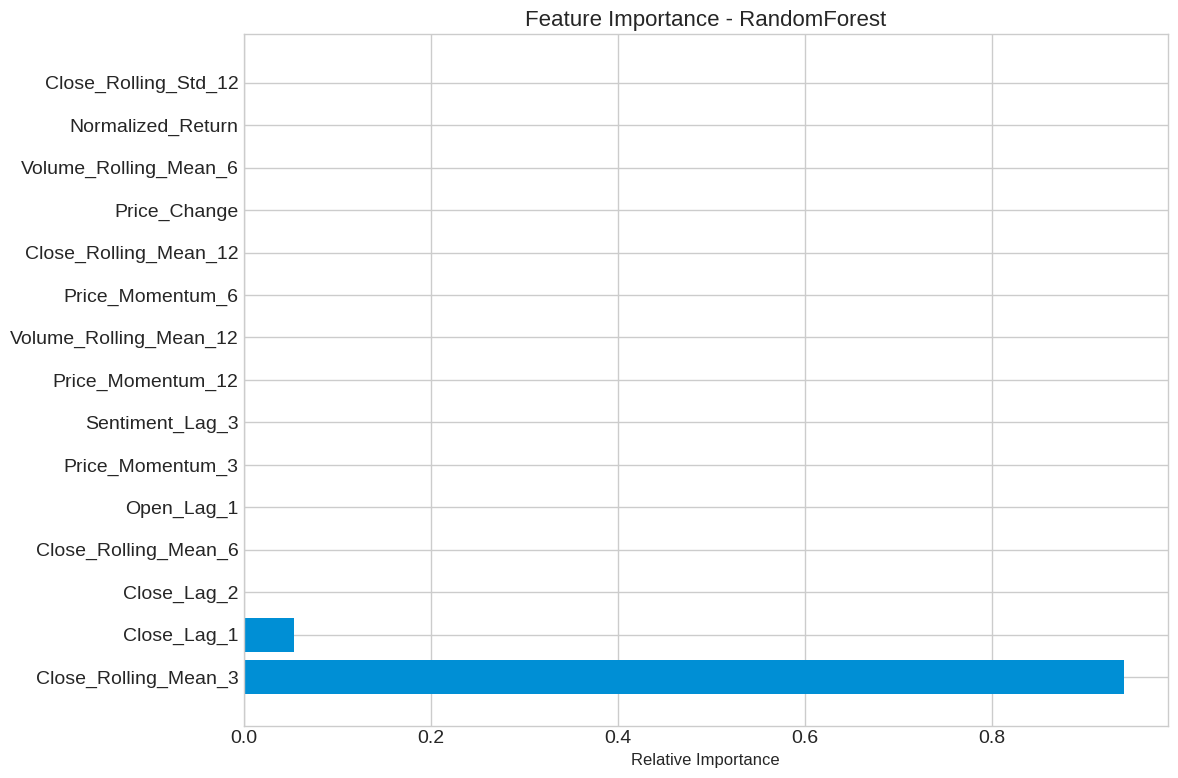


RandomForest Top 10 Features:
  1. Close_Rolling_Mean_3: 0.9417
  2. Close_Lag_1: 0.0535
  3. Close_Lag_2: 0.0018
  4. Close_Rolling_Mean_6: 0.0016
  5. Open_Lag_1: 0.0012
  6. Price_Momentum_3: 0.0000
  7. Sentiment_Lag_3: 0.0000
  8. Price_Momentum_12: 0.0000
  9. Volume_Rolling_Mean_12: 0.0000
  10. Price_Momentum_6: 0.0000


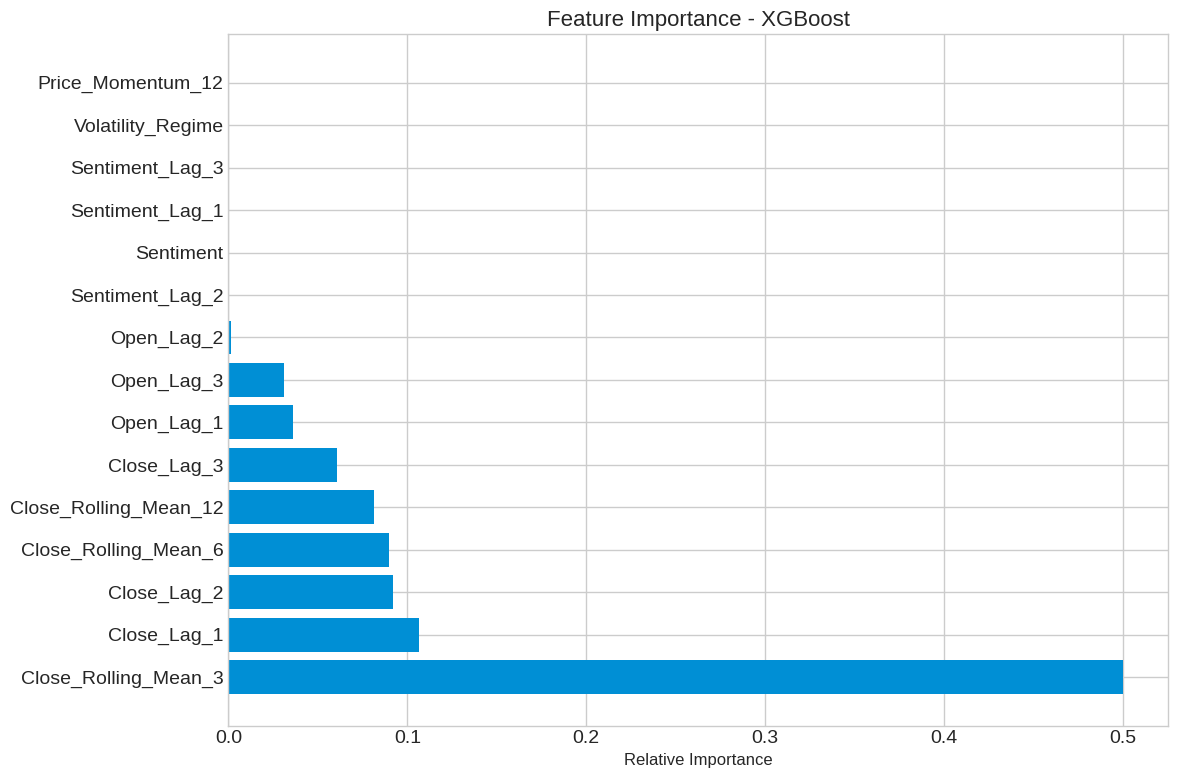


XGBoost Top 10 Features:
  1. Close_Rolling_Mean_3: 0.5001
  2. Close_Lag_1: 0.1067
  3. Close_Lag_2: 0.0920
  4. Close_Rolling_Mean_6: 0.0896
  5. Close_Rolling_Mean_12: 0.0812
  6. Close_Lag_3: 0.0605
  7. Open_Lag_1: 0.0361
  8. Open_Lag_3: 0.0313
  9. Open_Lag_2: 0.0016
  10. Sentiment_Lag_2: 0.0002

Step 10: Plotting predictions...


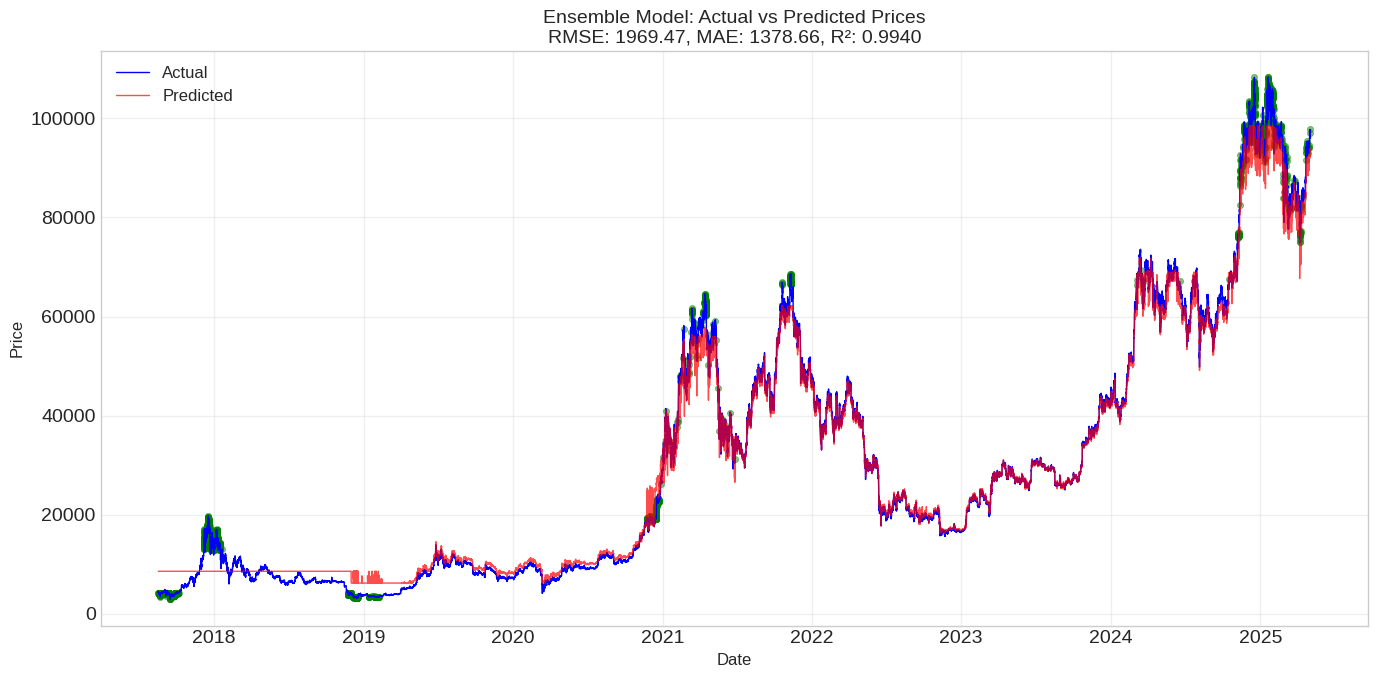

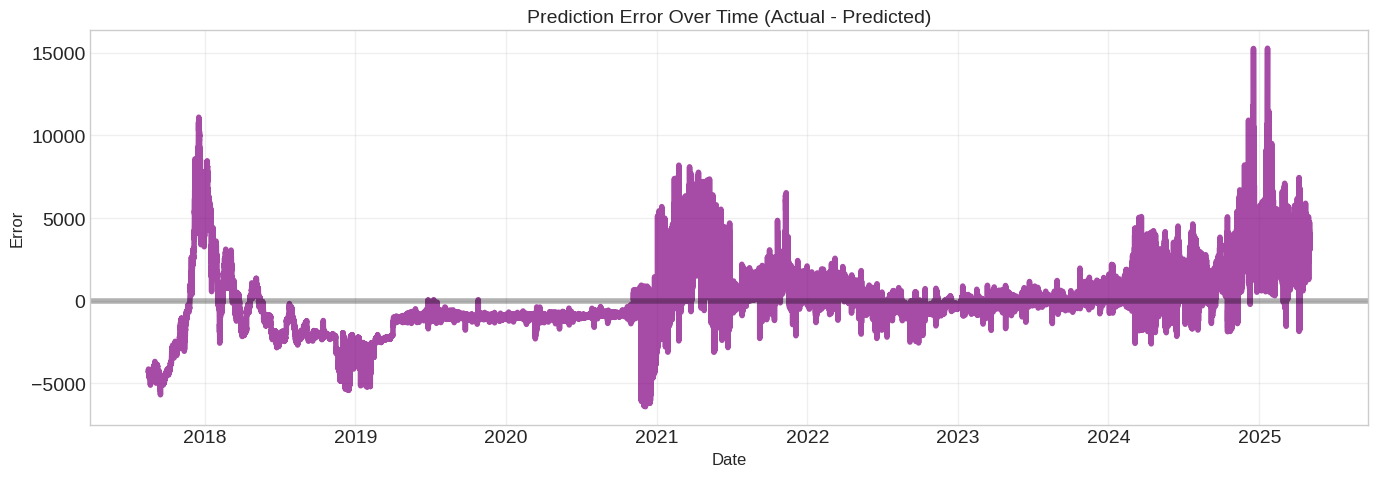


Step 11: Saving models...
Model saved to ./models/RandomForest_model.pkl
Model saved to ./models/Ridge_model.pkl
Model saved to ./models/XGBoost_model.pkl
Model saved to ./models/meta_model.pkl
Model saved to ./models/scaler.pkl
Model saved to ./models/tfidf_vectorizer.pkl
Model saved to ./models/svd_model.pkl
Done! All models saved to the './models/' directory.


({'RandomForest': RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=200,
                        random_state=42),
  'Ridge': Ridge(random_state=42),
  'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...)},
 XGBRegressor(base_score=None, booster=None, callbacks=None,
 

In [36]:
run_pipeline('merged_output.csv')